# Previsão de faturamento - Modelo autorregressivo ajustado ao produto `transporte`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento do produto `transporte` mês a mês.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# modelos
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Modelo autorregressivo com dados projetados

In [3]:
analise_produto = 'transporte'
fat = tswide[analise_produto].dropna()

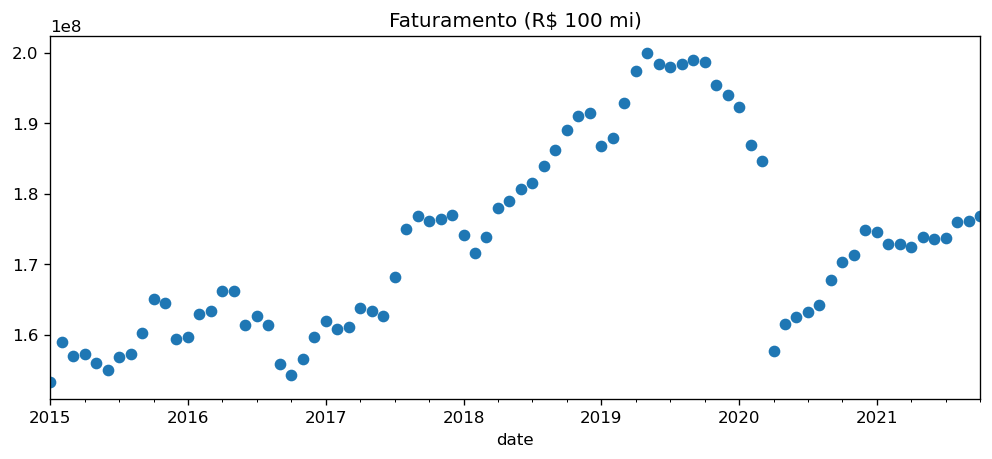

In [4]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ 100 mi)')
plt.show()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

Inicialmente é necessário construir a série "simulada" (detalhes em [`4-produto_transporte.ipynb`](../notebooks-exploration/4-produto_transporte.ipynb))

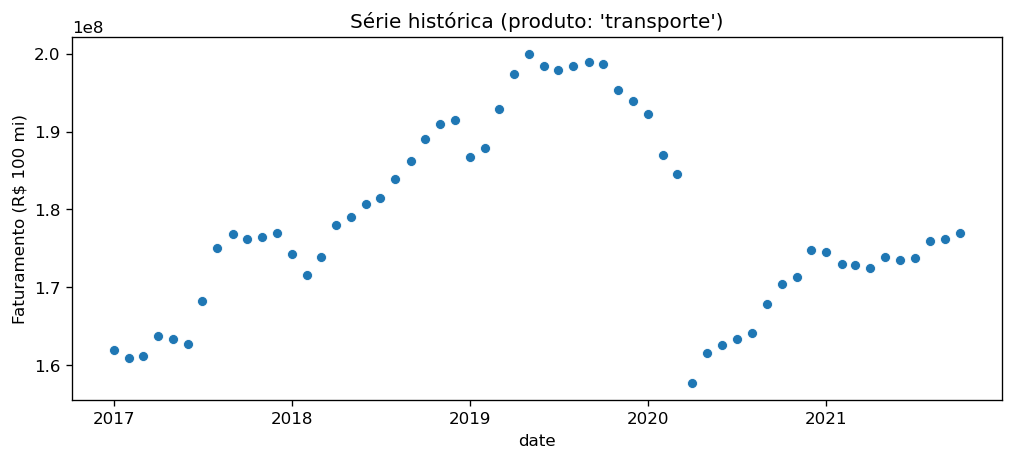

In [6]:
inicio = '2017-01'
inicio_pos_pandemia = '2020-05'

fat_replicar = fat[inicio:]
sns.scatterplot(data = fat_replicar)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 100 mi)")
plt.show()

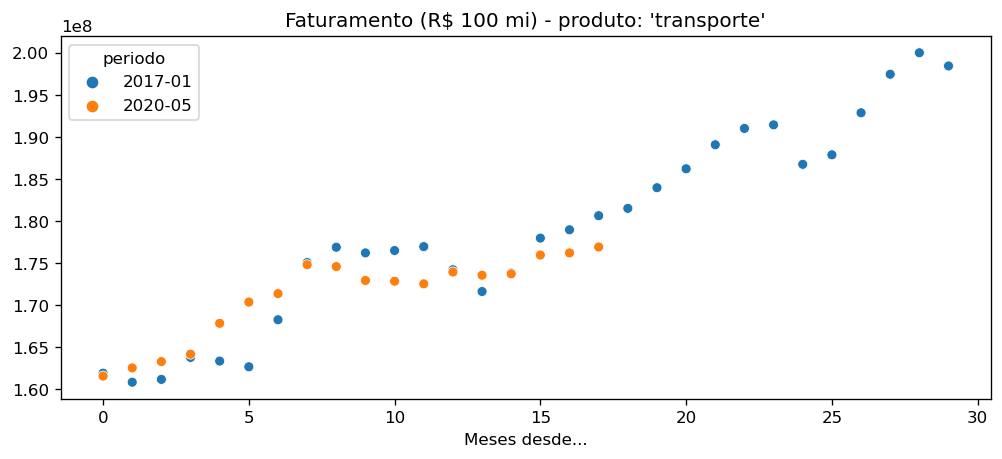

In [7]:
serie2 = fat_replicar[inicio_pos_pandemia:].reset_index(drop=True)
serie1 = fat_replicar[:'2019-06'].reset_index(drop = True)

comparacao_dict = {
    f'{inicio}': serie1,
    f'{inicio_pos_pandemia}': serie2,
}
comparacao_wide = (pd.DataFrame(comparacao_dict)
    .reset_index()
    .rename(columns = {'index': 'n_mes'})
)

comparacao = pd.melt(comparacao_wide, var_name = 'periodo', value_name = 'faturamento', id_vars = 'n_mes')

sns.scatterplot(data = comparacao, y = 'faturamento', x = 'n_mes', hue = 'periodo')

plt.xlabel('Meses desde...')
plt.ylabel('')
plt.title(f"Faturamento (R$ 100 mi) - produto: '{analise_produto}'")
plt.show()

In [8]:
col_pre_pandemia, col_pos_pandemia = comparacao_wide.columns[1:3]
comparacao_wide['faturamento_simulado'] = comparacao_wide[col_pos_pandemia].where(cond = comparacao_wide[col_pos_pandemia].notna(), other = comparacao_wide[col_pre_pandemia]) 
comparacao_wide['date'] = pd.date_range(start = col_pos_pandemia, periods = comparacao_wide.shape[0], freq = 'MS')
fat_sim = comparacao_wide.set_index('date')['faturamento_simulado']

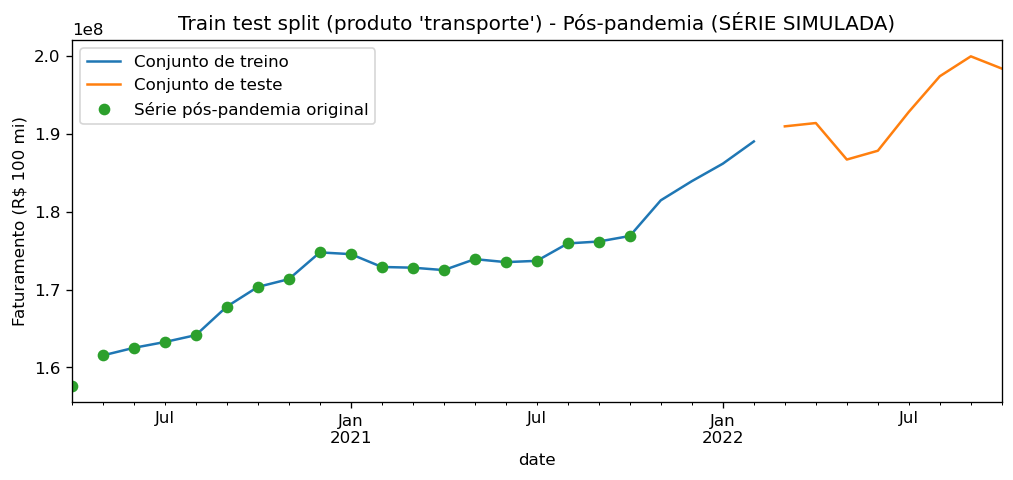

In [12]:
fat_pp = fat['2020-04':]

train_test_split_idx = int(fat_sim.shape[0] * 0.7 + 1)
fat_train = fat_sim[:train_test_split_idx]
fat_test = fat_sim[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
fat_pp.plot(label = 'Série pós-pandemia original', marker = 'o', linestyle = '')
plt.title(f"Train test split (produto '{analise_produto}') - Pós-pandemia (SÉRIE SIMULADA)")
plt.ylabel('Faturamento (R$ 100 mi)')
plt.legend()
plt.show()

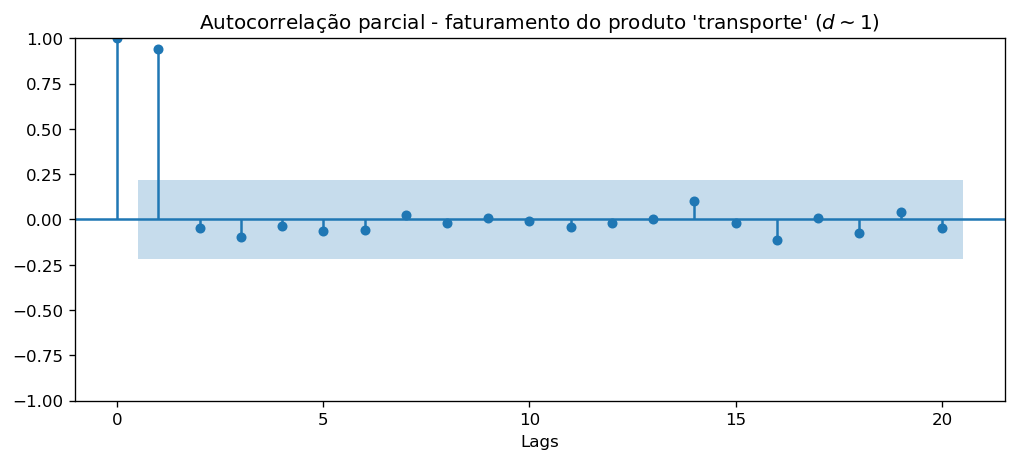

In [11]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

In [8]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = 2, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )

In [13]:
modelo = ARIMA(order = (0, 1, 0), seasonal_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

In [14]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -329.016
Date:                Wed, 17 Nov 2021   AIC                            662.033
Time:                        18:10:28   BIC                            664.122
Sample:                             0   HQIC                           662.486
                                 - 22                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.31e+06   3.47e+05      3.776      0.000     6.3e+05    1.99e+06
sigma2      2.377e+12   9.08e+11      2.619      0.009    5.99e+11    4.16e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.18   Prob(JB):                         0.74
Heteroskedasticity (H):               1.44   Skew:                             0.29
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

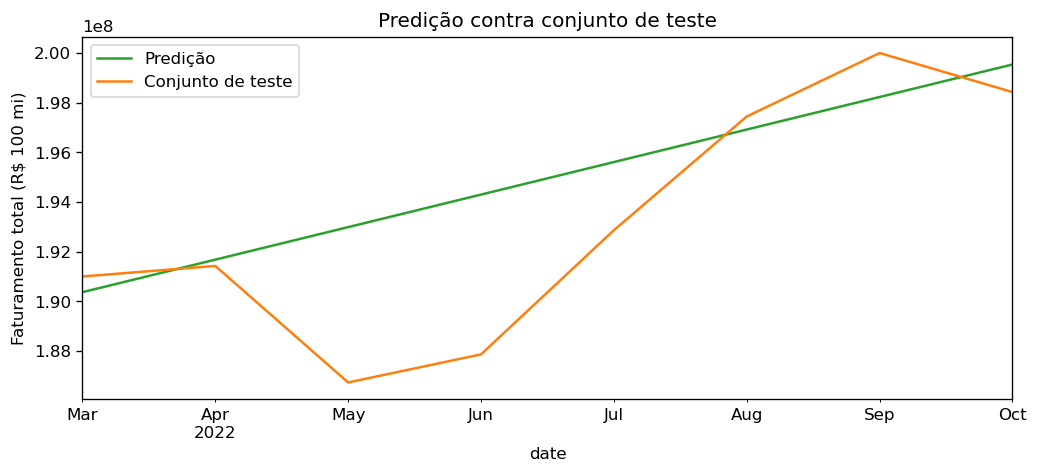

In [18]:
n_test_periods = fat_test.shape[0]
arr_preds = modelo.predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = fat_test.index[0], periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

palette = sns.color_palette(None, 4)
preds.plot(label = 'Predição', color = palette[2])
fat_test.plot(label = 'Conjunto de teste', color = palette[1])

plt.legend()
plt.ylabel('Faturamento total (R$ 100 mi)')
plt.title('Predição contra conjunto de teste')
plt.show()

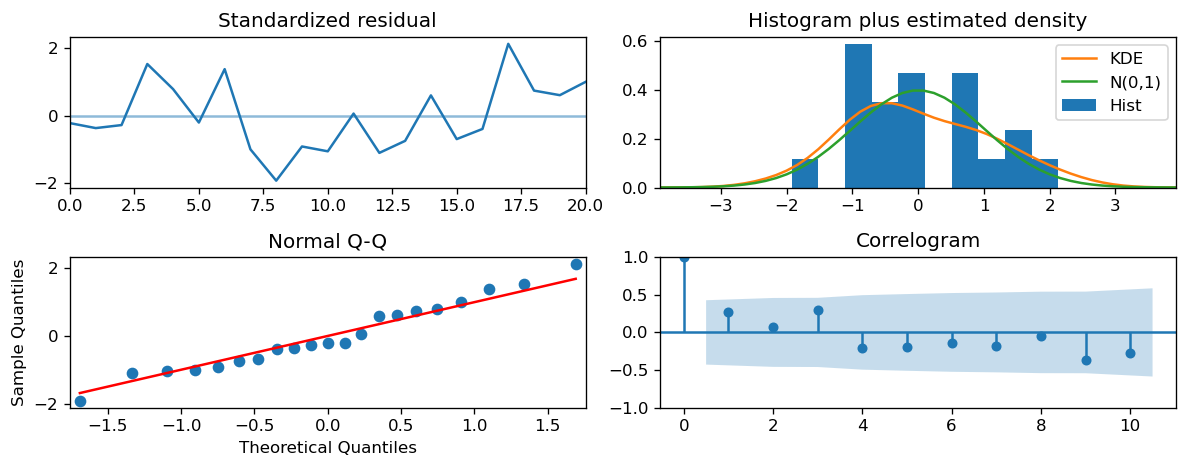

In [21]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [19]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
    MAPE: 1.297%
    RMSE: 3.414e+06
     MAE: 2.467e+06
      R²: 45.174%
 R² adj.: 39.403%


Vamos salvar o modelo atual para o faturamento do produto `alimenticio`.

In [20]:
with open(r'../models/produto_transporte_arima.pickle', 'wb') as arq_modelo_transporte:
    pickler = pickle.Pickler(file = arq_modelo_transporte)
    #pickler.dump(modelo)
